In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# User modifiable values

In [12]:
# path to eeg and marker files respectively
eeg_data_filepath = "data/sub-Mom/ses-S002/eeg/sub-Mom_ses-S002_task-A_run-001_eeg_20241112-163039_OutputFiles/IDUN - EEG_allExp.csv"
marker_data_filepath = "data/sub-Mom/ses-S002/eeg/sub-Mom_ses-S002_task-A_run-001_eeg_20241112-163039_OutputFiles/MarkerStream - Markers_allExp.csv"

# what target the participant was focusing on
# A = 1, B = 2, ...
target_marker = 'A'

# sampling rate of EEG headset
samplerate = 250.0

# time to view after event
after_event_ms = 600

## Read data

In [5]:
# read data from files
raw_eeg_data = pd.read_csv(eeg_data_filepath)
raw_marker_data = pd.read_csv(marker_data_filepath)

# convert data to numpy arrays
eeg_data_numpy = raw_eeg_data.to_numpy(na_value=np.nan)
marker_data_numpy = raw_marker_data.to_numpy(na_value=np.nan)

# transpose the data
eeg_data = eeg_data_numpy.T
marker_data_numpy = marker_data_numpy.T

# get timestamps from both data sets
eeg_timestamps = eeg_data[0, :]
marker_timestamps = marker_data_numpy[0, :]
marker_data = marker_data_numpy[1, :]


## Filter data

In [6]:
# notch filter to remove powerline noise (60 Hz)
notch_frequency = 60
b, a = signal.iirnotch(notch_frequency, 20, samplerate)
eeg_data_notch_filter = signal.filtfilt(b, a, eeg_data[1:, :])

# bandpass filter to remove noise outside of 1-50 Hz
high_pass_frequency = 1
low_pass_frequency = 30
b, a =  signal.iirfilter(int(3), [high_pass_frequency, low_pass_frequency], btype="bandpass", ftype="butter", fs=samplerate, output="ba")
eeg_data_filtered = signal.filtfilt(b, a, eeg_data_notch_filter)


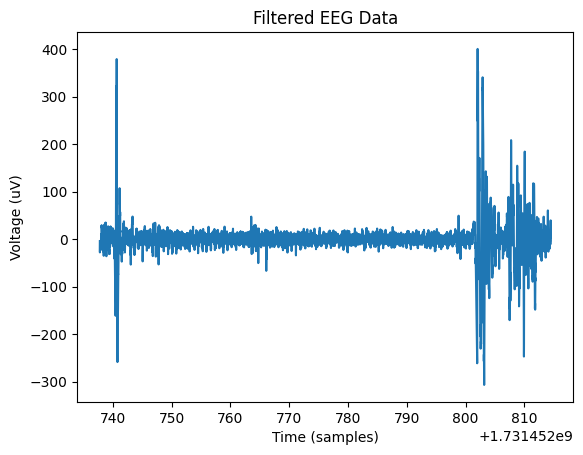

In [7]:
# plot the filtered data
plt.figure()
plt.plot(eeg_timestamps, eeg_data_filtered[0, :])
plt.title("Filtered EEG Data")
plt.xlabel("Time (samples)")
plt.ylabel("Voltage (uV)")
plt.show()

# Trim out bad sections and re-plot

EEG Data Shape: (1, 18780)
Timestamp Shape: (18780,)
EEG Data Shape: (1, 17198)
Timestamp Shape: (17198,)


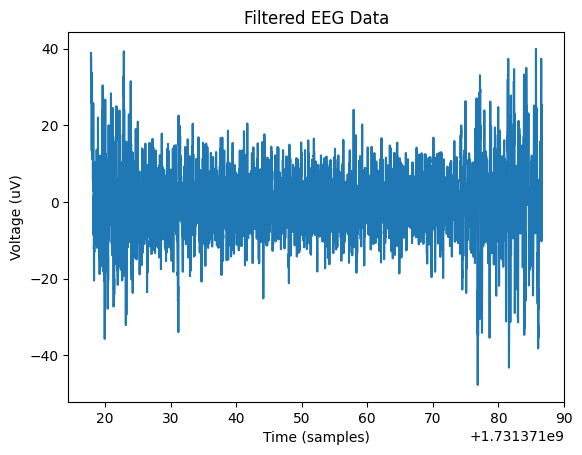

In [176]:
# find the index of the random spike
bad_value = np.max(eeg_data_filtered[0:])
spike_index = np.where(eeg_data_filtered == bad_value)

spike_index = spike_index[1][0]
# add offset to min_index to get a better view of the spike
spike_index = spike_index + 1500

print(f"EEG Data Shape: {eeg_data_filtered.shape}")
print(f"Timestamp Shape: {eeg_timestamps.shape}")

eeg_data_filtered = eeg_data_filtered[:, spike_index:]
eeg_timestamps = eeg_timestamps[spike_index:]
print(f"EEG Data Shape: {eeg_data_filtered.shape}")
print(f"Timestamp Shape: {eeg_timestamps.shape}")

np.savetxt("data/sub-Nathan/ses-S001/eeg/sub-Nathan_ses-S001_task-Default_run-001_eeg_20241111-173002_OutputFiles/IDUN - EEG_allExp_filtered.csv", eeg_data_filtered[:], delimiter=",")
np.savetxt("data/sub-Nathan/ses-S001/eeg/sub-Nathan_ses-S001_task-Default_run-001_eeg_20241111-173002_OutputFiles/MarkerStream - Markers_allExp_filtered.csv", eeg_timestamps, delimiter=",")


# plot the filtered data
plt.figure()
plt.plot(eeg_timestamps, eeg_data_filtered[0, :])
plt.title("Filtered EEG Data")
plt.xlabel("Time (samples)")
plt.ylabel("Voltage (uV)")
plt.show()

# Get goal timestamps

In [13]:
# helper function
def get_index_of_nearest_timestamp(goal_timestamp, timestamps):
    return np.argmin(np.abs(timestamps - goal_timestamp))

# get timestamps from when the target marker was shown
p300_timestamps = []
for i in range(len(marker_data)):
    if marker_data[i] == target_marker:
        p300_timestamps.append(marker_timestamps[i])

# get coordinating timestamps from the EEG data
p300_eeg_timestamps = []
for t in p300_timestamps:
    p300_eeg_timestamps.append(eeg_timestamps[get_index_of_nearest_timestamp(t, eeg_timestamps)])

In [ ]:
print(p300_eeg_timestamps[0])
print(p300_timestamps[0])

print(f"Number of P300 events: {len(p300_timestamps)}")
print(f"eeg timestamps: {p300_eeg_timestamps}")
print(f"marker timestamps: {p300_timestamps}")

[1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634]
1731452963.238765
Number of P300 events: 20
eeg timestamps: [1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634, 1731452814.488634]
marker timestamps: [1731452963.238765, 1731452966.5921478, 1731452969.945531, 1731452971.4932458, 1731452973.2989137, 1731452977.6841066, 1731452979.2318218, 1731452983.1011095, 

# Epoching

In [183]:
fs = 250    # Sampling rate in Hz
samples_per_ms = fs / 1000
samples_after_flash = int(after_event_ms * samples_per_ms)  # 800 ms after flash
print(f"getting {samples_after_flash} samples after flash")

# Mark the P300 events in the EEG data
eeg_marked = np.vstack((eeg_timestamps, eeg_data_filtered, np.zeros(eeg_data_filtered.shape[1])))

for t in p300_eeg_timestamps:
    # how far is each timestamp from the target timestamp
    distances = np.abs(eeg_timestamps - t)
    # find the index of the closest timestamp
    index = np.argmin(distances)
    # mark the event
    eeg_marked[2, index] = 1

event_indices = np.where(eeg_marked[2, :] == 1)[0]
print(f"event indices: {event_indices}")
epochs = []

for e in event_indices:
    end_index = min(e + samples_after_flash, eeg_marked.shape[1])

    print(f"getting data in range {e} to {end_index}")

    epoch = eeg_marked[:, e:end_index]
    epochs.append(epoch)

epochs = np.array(epochs)
print(f"Number of epochs: {len(epochs)}")
print(f"Shape of epochs: {epochs.shape}")


getting 150 samples after flash
event indices: [    0 17197]
getting data in range 0 to 150
getting data in range 17197 to 17198


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

In [180]:
# cut bad epochs
bad_epochs = [0, 10]
epochs = np.delete(epochs, bad_epochs, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

In [182]:
# plot all epochs
no_samples = epochs.shape[2]
time = np.linspace(0, after_event_ms, no_samples)

plt.figure() 
for i in range(epochs.shape[0]):
    plt.plot(time, epochs[i, 1, :], label=f"Epoch {i}")

plt.title("P300 Epochs")
plt.xlabel("Time (ms)")
plt.ylabel("EEG Amplitude (uV)")
plt.legend(loc="upper right", fontsize='small')
plt.show()

AttributeError: 'list' object has no attribute 'shape'

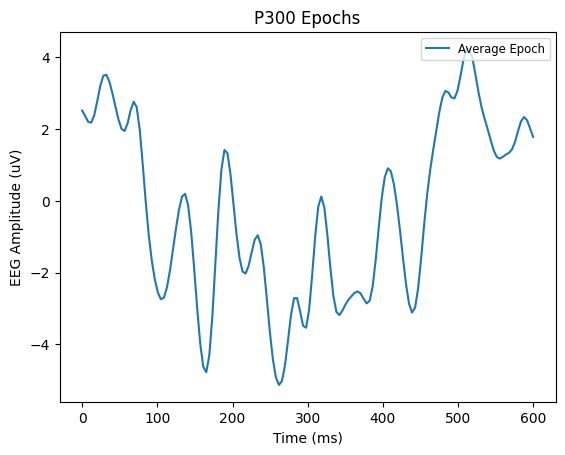

In [ ]:
# average the epochs
average_epoch = np.mean(epochs[:, 1, :], axis=0)

plt.figure() 
plt.plot(time, average_epoch, label=f"Average Epoch")

plt.title("P300 Epochs")
plt.xlabel("Time (ms)")
plt.ylabel("EEG Amplitude (uV)")
plt.legend(loc="upper right", fontsize='small')
plt.show()